In [ ]:
##Problema 18

Please upload **data18_frank.xlsx**


Saving data18_frank.xlsx to data18_frank (1).xlsx


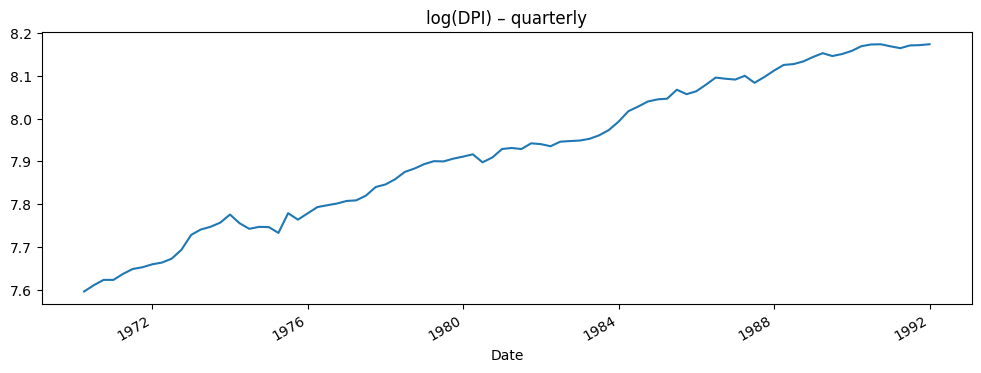

--- ADF test: log(DPI) (level) ---
ADF statistic = -1.4407
p-value      = 0.5626
Critical values: {'1%': '-3.513', '5%': '-2.897', '10%': '-2.586'}



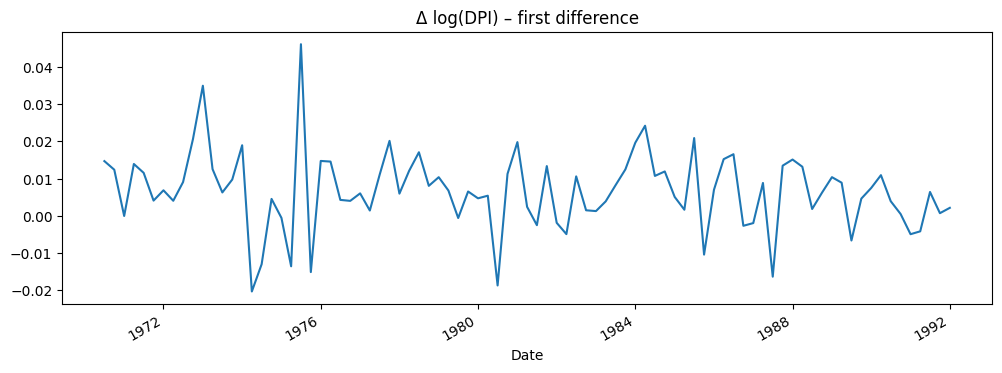

--- ADF test: Δ log(DPI) ---
ADF statistic = -4.6692
p-value      = 0.0001
Critical values: {'1%': '-3.513', '5%': '-2.897', '10%': '-2.586'}



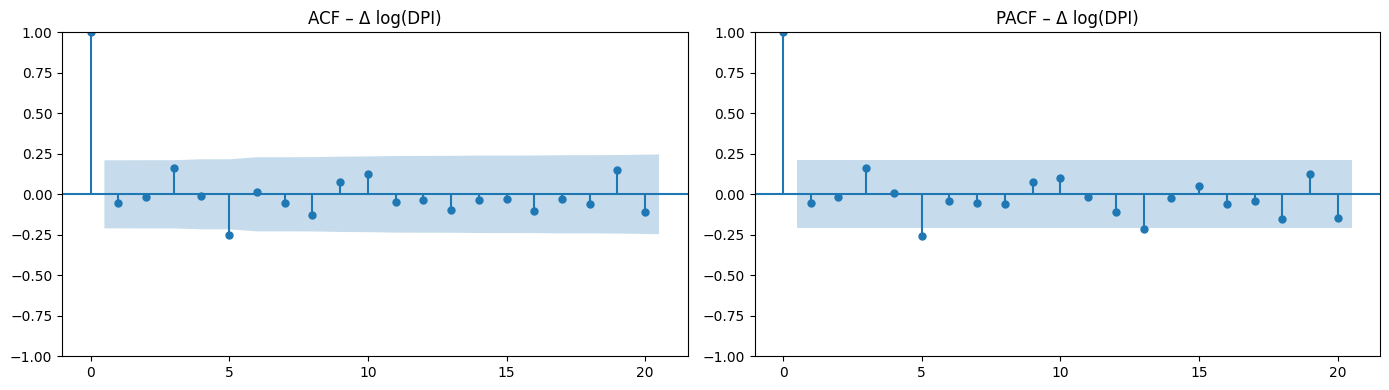

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

                               SARIMAX Results                                
Dep. Variable:                log_DPI   No. Observations:                   88
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 270.603
Date:                Sun, 02 Nov 2025   AIC                           -535.206
Time:                        22:25:11   BIC                           -527.808
Sample:                    03-31-1970   HQIC                          -532.227
                         - 12-31-1991                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.004    227.570      0.000       0.991       1.008
ma.L1         -0.9856      0.122     -8.047      0.000      -1.226      -0.746
sigma2         0.0001   1.75e-05      6.469      0.0

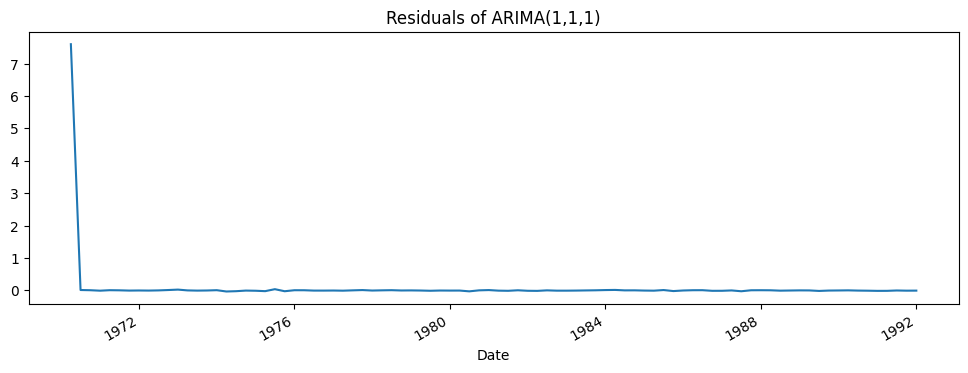

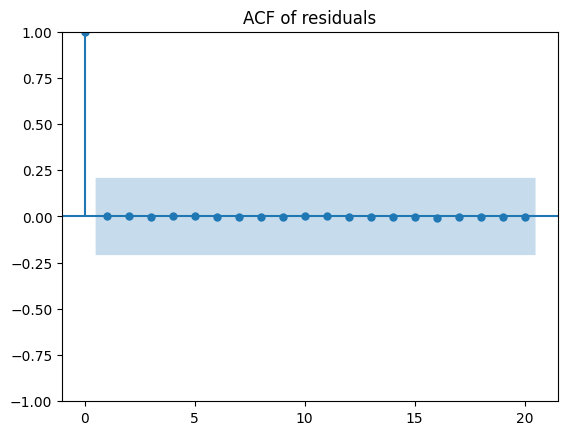


Ljung-Box test (lag 10):
     lb_stat  lb_pvalue
10  0.001026        1.0


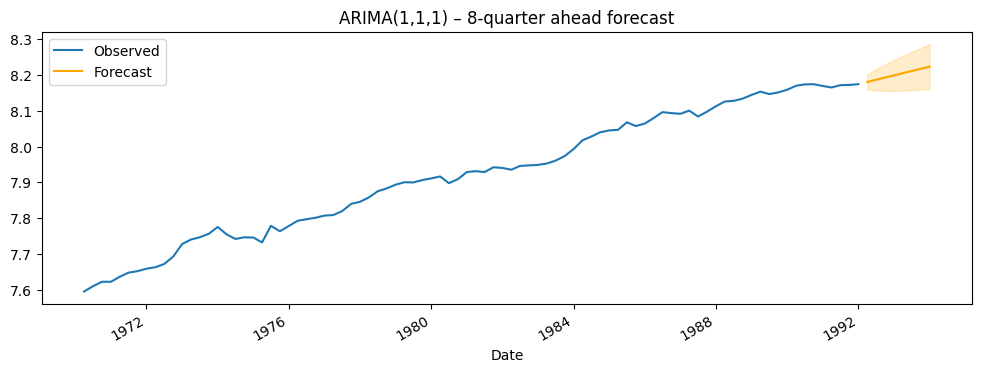

In [2]:
# --------------------------------------------------------------
#  ARIMA modelling of log(DPI) – Gujarati 22.11 (Table 21.1)
# --------------------------------------------------------------

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import files

# 2. Upload the Excel file
print("Please upload **data18_frank.xlsx**")
uploaded = files.upload()                     # <-- you will be prompted

# 3. Load the sheet that contains Table 21.1
df = pd.read_excel(list(uploaded.keys())[0], sheet_name="Table 21.1")

# --------------------------------------------------------------
# 4. Build a proper quarterly DatetimeIndex
# --------------------------------------------------------------
def year_to_quarter_end(y):
    """Convert a float like 1970.1 → last day of Q1 1970 (1970-03-31)"""
    year  = int(y)                                   # integer part
    q     = int(round((y % 1) * 10))                 # 1,2,3 or 4
    month = 3 * q                                    # 3,6,9,12
    return pd.Period(year=year, quarter=q, freq='Q').end_time

# Apply the conversion and set as index
df['Date'] = df['YEAR'].apply(year_to_quarter_end)
df = df.set_index('Date').drop(columns=['YEAR'])

# --------------------------------------------------------------
# 5. Create the series: log(DPI)   (PDI column = level of DPI)
# --------------------------------------------------------------
df['log_DPI'] = np.log(df['PDI'])

# --------------------------------------------------------------
# 6. Identification
# --------------------------------------------------------------
# 6.1 Plot the series
plt.figure(figsize=(12,4))
df['log_DPI'].plot()
plt.title('log(DPI) – quarterly')
plt.show()

# 6.2 ADF test on the level
def adf_report(series, name):
    res = adfuller(series.dropna())
    print(f'--- ADF test: {name} ---')
    print(f'ADF statistic = {res[0]:.4f}')
    print(f'p-value      = {res[1]:.4f}')
    print('Critical values:', {k:f'{v:.3f}' for k,v in res[4].items()})
    print('')

adf_report(df['log_DPI'], 'log(DPI) (level)')

# 6.3 First difference (most economic series need d=1)
df['dlog_DPI'] = df['log_DPI'].diff().dropna()

plt.figure(figsize=(12,4))
df['dlog_DPI'].plot()
plt.title('Δ log(DPI) – first difference')
plt.show()

adf_report(df['dlog_DPI'].dropna(), 'Δ log(DPI)')

# 6.4 ACF / PACF of the differenced series
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_acf (df['dlog_DPI'].dropna(), lags=20, ax=ax[0], title='ACF – Δ log(DPI)')
plot_pacf(df['dlog_DPI'].dropna(), lags=20, ax=ax[1], title='PACF – Δ log(DPI)')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 7. Estimation – try ARIMA(1,1,1) (change p,q after you inspect the plots)
# --------------------------------------------------------------
model = ARIMA(df['log_DPI'], order=(1,1,1))   # d=1 → uses the differenced series internally
fit   = model.fit()

print(fit.summary())

# --------------------------------------------------------------
# 8. Diagnostics – residuals must look like white noise
# --------------------------------------------------------------
resid = fit.resid

plt.figure(figsize=(12,4))
resid.plot()
plt.title('Residuals of ARIMA(1,1,1)')
plt.show()

plot_acf(resid, lags=20, title='ACF of residuals')
plt.show()

# Ljung-Box test for residual autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(resid, lags=[10], return_df=True)
print('\nLjung-Box test (lag 10):')
print(lb)

# --------------------------------------------------------------
# 9. (Optional) Forecast next 8 quarters
# --------------------------------------------------------------
forecast_steps = 8
forecast = fit.get_forecast(steps=forecast_steps)
conf_int = forecast.conf_int()

plt.figure(figsize=(12,4))
df['log_DPI'].plot(label='Observed')
forecast.predicted_mean.plot(label='Forecast', color='orange')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='orange', alpha=0.2)
plt.legend()
plt.title('ARIMA(1,1,1) – 8-quarter ahead forecast')
plt.show()